# 자동차 연비 예측하기 : 회귀  

### 회귀(Regression) 문제는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다.  

##### 우리는 Auto MPG 데이터셋을 가지고 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 문제를 풀어볼 것 입니다.

출처 : https://www.tensorflow.org/tutorials/keras/regression?hl=ko

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


데이터 셋을 다운로드 합니다.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\user\\.keras\\datasets\\auto-mpg.data'

판다스를 사용하여 데이터를 읽습니다.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


판다스를 이용하여 csv 파일을 읽어옵니다.  
파라미터로는 dataset_path(데이터 경로), names(문자열 목록이어야 합니다.), na_values('?'로 처리된 문자열 또한 NaN값으로 인식합니다.)  
conmment(줄이 tap문자 '\t'일경우 주석으로 처리되어 무시합니다.), sep(공백으로 csv에서 파일 값들을 구분합니다.), skipinitialspace(True면, 데이터 앞부분의 공백을 무시합니다)로 구성되어 있습니다.  
dataset.tail()은 dataset의 마지막 5줄을 보여줍니다.  
MPG(연비), Cylinders(실린더 개수), Displacement(배기량), Horespower(마력), Weight(중량), Accleration(가속 능력), Model Year(모델 년도), Origin(1 : USA, 2 : Europe, 3 : Japen)

데이터를 정제합니다.  
데이터의 일부가 누락되어있을 경우, 예측하는 모델이 정확하게 예측을 하지 못할 수도 있기 때문에 scaling을 해줍니다.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

마력을 나타내는 Horsepower에 결측값이 6개 있는것을 확인할 수 있습니다.  

문제를 간단하게 만들기 위해서 결측값을 날립니다.

In [5]:
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('Origin')

결측값이 사라진것을 볼 수 있습니다.  

"Origin"은 수치형이 아니고 범주형이므로 원-핫 인코딩으로 변경해줍니다.

In [16]:
dataset['USA'] = (origin == 1)*1.0 # origin값이 1일 경우 1.0으로 값을 저장합니다.
dataset['Europe'] = (origin == 2)*1.0 # origin 값이 2일 경우 1.0으로 값을 저장합니다.
dataset['Japan'] = (origin == 3)*1.0 # origin 값이 3일 경우 1.0으로 값을 저장합니다.
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 데이터 셋을 훈련 세트와 테스트 세트로 분할하기

#### 이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

#### 테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

데이터를 train set과 test set으로 나눕니다. 비율은  8:2로 나누고, random_state를 0 으로 설정합니다. 즉, 매번 같은 샘플이 선택 됩니다.  
결과적으로, dataset에서 무작위로 8:2 비율로 train set와 test set으로 나눕니다.

몇가지 Column들을 뽑아서 산점도를 그려봅니다.   

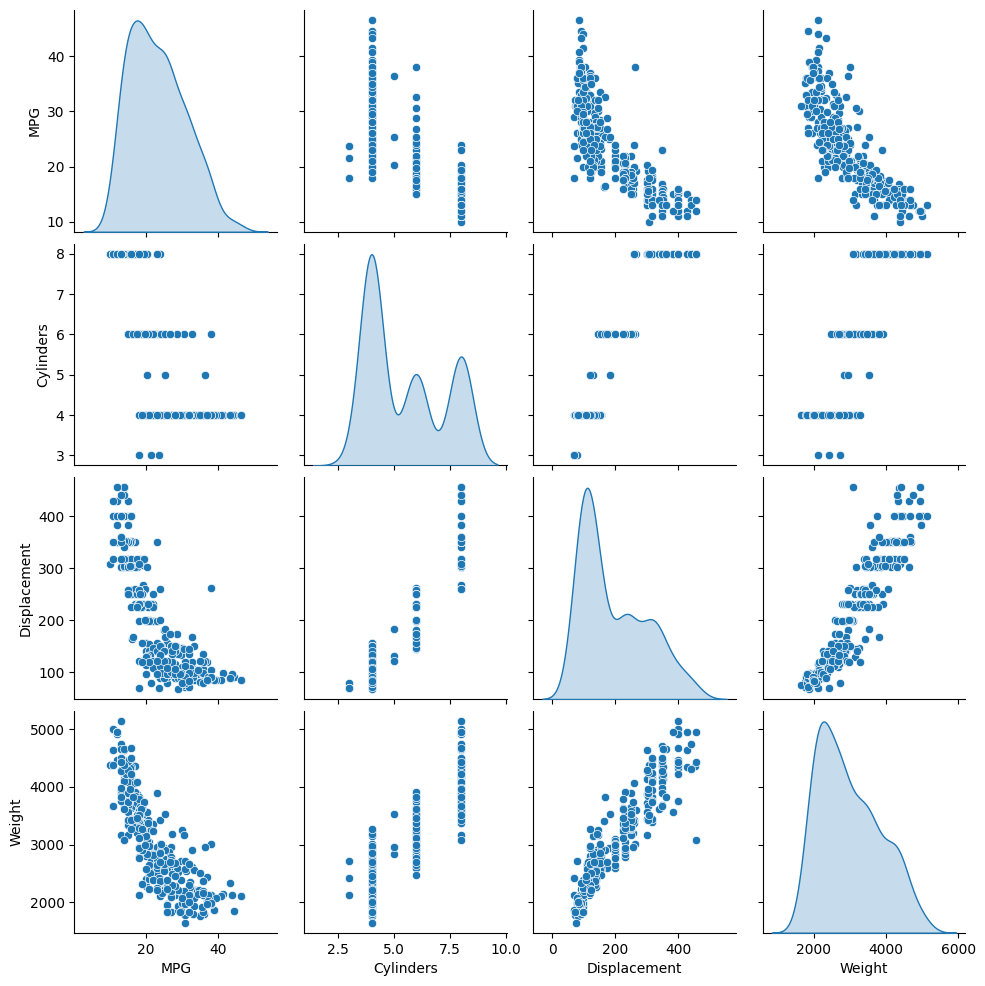

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 알아봅니다.

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


# 특성과 레이블 분리하기  

### 특성에서 타깃 값(MPG)를 분리하고, 이 레이블을 예측하기 위한 모델을 만듭니다.

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

#### 특성의 스케일과 범위가 다르면 정규화(Normalization)를 하는것을 권장합니다. 특성을 정규화 하지 않으면 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어지기 쉽습니다.  

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

norm이라는 함수를 생성합니다. norm 함수는 데이터로 들어온 x에서 각 평균을 빼주고, 그 값을 표준 편차로 나누는 작업을 합니다.  
그리고 train set과 test set을 norm 함수에 넣어서 정규화된 set의 변수에 새로 저장합니다.

# 모델 만들기

#### 이 예제 에서는 두 개의 완전연결 (densely connected)은닉층으로 Sequential 모델을 만듭니다.  출력층은 하나의 연속적인 값을 반환합니다.

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

model.summary()를 사용하여 모델에 대한 간단한 정보를 출력합니다.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


10개의 훈련 샘플을 하나의 배치로 만들어 mdoel.predict 메서드를 호출해줍니다.

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.3038205 ],
       [-0.22271244],
       [-0.31719896],
       [-0.05086604],
       [-0.25267193],
       [-0.16162147],
       [-0.3030222 ],
       [-0.39316335],
       [-0.2866595 ],
       [-0.5307687 ]], dtype=float32)

In [18]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

model.fit과 model.predict의 차이점은, model.fit()은 파라미터로 입력 받은 데이터를 통해, 모델을 훈련시키는 메서드이고, model.predict()는 주어진 입력 데이터를 통하여 학습된 모델이 새로운 데이터에 대한 예측을 수행하게 하는 메서드 입니다.  
위의 경우, 1000번의 epoch를 반복하여 validation set은 train set의 20%로 설정하고, 모델을 학습 시킵니다.

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.332436,0.967411,2.332436,10.658052,2.617169,10.658052,995
996,2.370280,0.945704,2.370280,10.052975,2.547061,10.052975,996
997,2.279159,0.960843,2.279159,10.184422,2.553434,10.184422,997
998,2.338275,0.988202,2.338275,10.136549,2.566080,10.136549,998
999,2.429310,1.000491,2.429310,10.021060,2.544488,10.021060,999


위의 그래프는 평균 절대 오차(MAE)를 사용하여 학습 결과를 나타낸 그래프이고, 아래 그래프는 평균 제곱 오차 (MSE)를 사용하여 학습 결과를 나타낸 그래프 입니다.

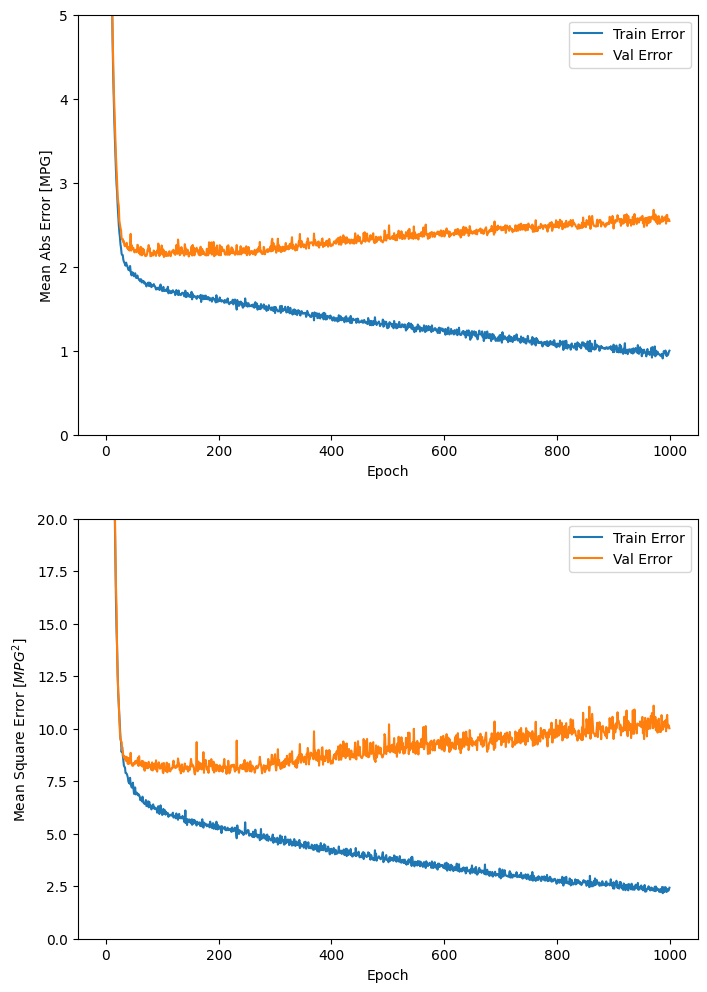

In [20]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

백번 미만의 횟수에서 모델이 더 이상 학습을 하는 것에 대해 별로 의미가 없는 것을 확인 하였습니다.  
따라서 학습의 성능 향상이 없을 때, 자동으로 early stopping을 하는 callback을 사용합니다.


...........................................................

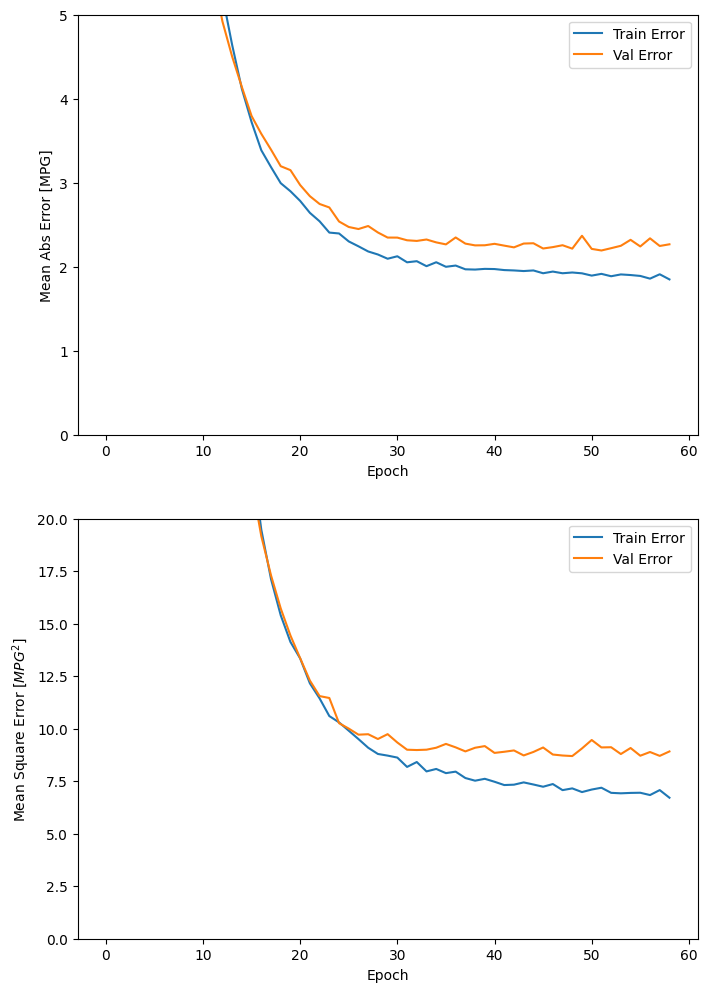

In [21]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

위 그래프를 확인 한 결과, 검증 세트의 오차가 약 +/- 2MPG 입니다.

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.9506 - mae: 1.8442 - mse: 5.9506 - 38ms/epoch - 13ms/step
테스트 세트의 평균 절대 오차:  1.84 MPG


model.evaluate() 메서드는 이전에 사용하지 않았던 데이터를 가지고 모델의 성능을 확인하는 방법입니다.  
주의할 점은, model.compile를 꼭 하고 나야 사용할 수 있습니다.

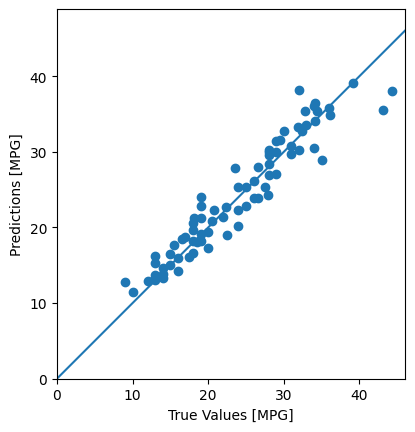

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

오차의 분포 같은 경우, 훈련 샘플의 수가 매우 작아서 완벽한 가우시안 분포의 모양은 아니지만, 나름 유사하게 생겼습니다.

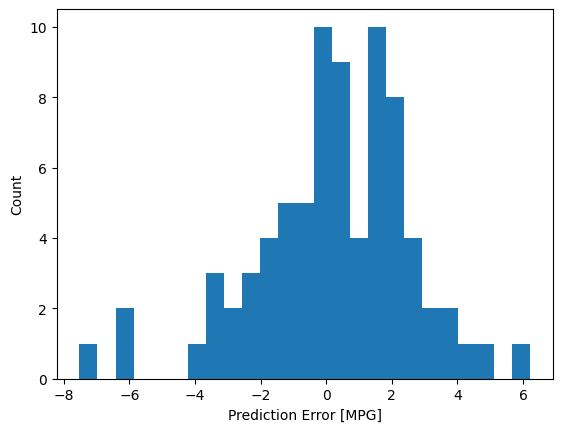

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")